# Assignment 1 Scientific Computing 

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numba 
from matplotlib.animation import FuncAnimation
import os
import pickle as pkl
from IPython.display import HTML

In [2]:
import src.solutions as solutions
import src.visualizations as visualizations


In [3]:
colors = ["orange", "blue", "green", "purple", "brown"]

## Part 1

first draft on assignment 1a, wrote it as an iterative scheme over time and space, saving the two previous time values for the computation of the next time point

The discretized wave equation becomes (with functions from solutions): 

time_approx_1a(deltat, time, func, x) = c^2* spat_approx_1a(deltax, time, func, x, L)

you can rewrite this to get the values of the next time point

### B

Euler's method 

f_x+1 = f_x + h * f'_x

(c*delta t)/delta x < 1 for stable computation 
looking at this method, you can derive that in the first two time-points, the function follows the exact same curve as the derivative (f'_x) is 0

### Plotted snapshots of the wave at different times

In [ ]:
#choose out of options 1, 2 or 3

L = 1
N = 100
c = 1
deltat= 0.001
iterations = 30000
overall_solutions=[]
for i in range(3):
    overall_solution, xs = solutions.one_b_wrapper(i+1, L, N, c, deltat, iterations)
    overall_solutions.append(overall_solution)

visualizations.visualization_1b(overall_solutions, xs)

### Wave Animation 

In [ ]:
# initial values for the wave equation 
visualizations.animate_1c(L, N, c, deltat)


The equations for the boundaries:

c^(k+1)_(0, j) = 1 -> top row <br>
c^(k+1)_(N-1, j) = 0 -> bottom row <br>
c^(k+1)_(i, 0) = c^(k+1)_(i, N - 2) -> first column <br>
c^(k+1)_(i, -1) = c^(k+1)_(i, 1) -> last column <br>

## Diffusion

In [4]:
# values used for initial diffusion setup 
# main parameter values (for discretization)
N = 100
L = 1.0
D = 1

# setp sizes
dx = L / N
dt = 0.25 * dx**2

# initial setup
gamma = (D * dt) / (dx**2) #what is this gamma
num_steps = int(1.0/ dt)
y_values = np.linspace(0, 1, N)
c = solutions.initialize_grid(N)

par_values = (c, num_steps, N, gamma, dt)

#### Comparison analytical with numerical solution

In [ ]:

# parse data and check directory layout and file existence or create new data
create_new_data = False
data_file = "2D_diffusion.pkl"
all_c, times = solutions.check_and_parse_data(data_file, create_new_data, par_values)

# visualize the data together with analytical solution. 
# visualizations.plot_analytical_solution(y_values, all_c, times, D)
visualizations.plot_analytical_solution(y_values, all_c, times, D)
# t values 0, 0.001, 0.01, 0.1, 1.0
visualizations.plot_five_states(all_c, times)

### Snapshot of 5 Diffusion configurations 

In [ ]:

# data parsing/generation 
data_file = "2D_diffusion_comparison.pkl"
create_new_data = False
all_c, times = solutions.check_and_parse_data(data_file, create_new_data, par_values)

# visualizations.plot_simulation_without_animation(all_c, N)

# animation 
%matplotlib inline
anim = visualizations.animate_2f(solutions.update, c, num_steps, N, gamma, dt)
HTML(anim.to_jshtml())

I

Show how the convergence measure δ in eq. (14) depends on the number
 of iterations k for each of the methods. A log-lin plot may be suitable. For SOR,
 choose a few representative values for ω.

In [ ]:
# parameters
p_values = np.arange(1, 10)
omegas = [1, 1.5]
N = 50
max_iters = 10000

iterations_jacobi = [solutions.sequential_jacobi(N=N, tol=10.0**-p, max_iters=max_iters) for p in p_values]
iterations_gauss_seidel = [solutions.sequential_gauss_seidel(N=N, tol=10.0**-p, max_iters=max_iters) for p in p_values]

for omega in omegas:
    iterations_sor = [solutions.sequential_SOR(N=N, tol=10.0**-p, max_iters=max_iters, omega=omega) for p in p_values]

visualizations.visualization_1i(p_values, iterations_jacobi, iterations_gauss_seidel, iterations_sor)

J 

In the SOR method, find the optimal ω. How does it depend on N?.

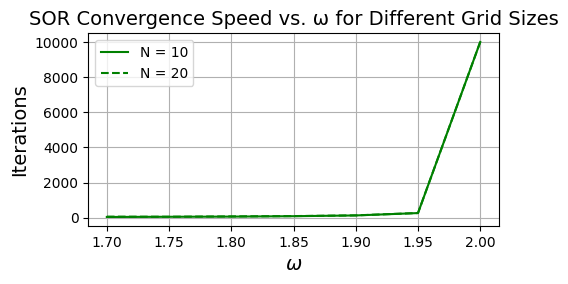

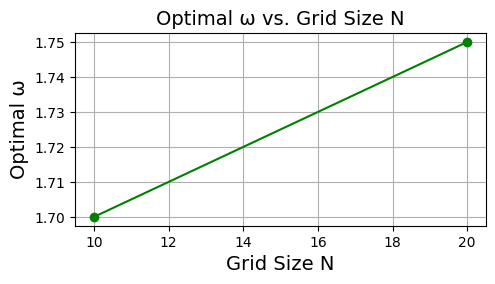

In [ ]:
# parameters
omega_range = np.arange(1.7, 2.0, 0.05)
N_values = [10, 20, 50, 100]
max_iters = 10000 # delete this later (also already above)

optimal_omegas = []
iters_N = {}

for N in N_values:
    best_omega = None
    min_iters = float('inf')

    iters_omega = []

    for omega in omega_range:
        iters = solutions.sequential_SOR(N=N, tol=1e-6, max_iters=max_iters, omega=omega)

        iters_omega.append(iters)

        if iters < min_iters:
            min_iters = iters
            best_omega = omega

    optimal_omegas.append(best_omega)
    iters_N[N] = iters_omega

visualizations.visualization_1j_omega_iters(iters_N, omega_range, colors=colors)
visualizations.visualization_1j_N_omegas(N_values, optimal_omegas, colors=colors)